In [6]:
pip install matplotlib
pip install networkx
pip install pandas

SyntaxError: invalid syntax (<ipython-input-6-ab6d592d883b>, line 1)

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('./dati-json/dpc-covid19-ita-province.json') as f:
    covid19_provinces_data = json.load(f)

with open('./dati-json/dpc-covid19-ita-regioni.json') as f:
    covid19_regions_data = json.load(f)

In [3]:
data = []
for province in covid19_provinces_data:
    province_denomination = province['sigla_provincia']
    province_date = province['data']
    # Es. ('FI', '2020-02-24T...', all data on that row)
    # the first 2 values will be used as key
    data.append([province_denomination, province_date, province.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
province_info = []
for province in data:
    index.append([province[0], province[1]]) # (Name, date)
    province_info.append(province[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
dati = pd.DataFrame(province_info, index=index, columns=covid19_provinces_data[0].keys())
# and drop some usless columns
dati = dati.drop(columns=['codice_regione', 'denominazione_provincia', 'stato', 'codice_provincia', 'note_it', 'note_en'])
dati

data denominazione_regione  \
   2020-02-24T18:00:00  2020-02-24T18:00:00               Abruzzo   
   2020-02-24T18:00:00  2020-02-24T18:00:00            Basilicata   
   2020-02-24T18:00:00  2020-02-24T18:00:00          P.A. Bolzano   
   2020-02-24T18:00:00  2020-02-24T18:00:00              Calabria   
   2020-02-24T18:00:00  2020-02-24T18:00:00              Campania   
...                                     ...                   ...   
VV 2020-05-15T17:00:00  2020-05-15T17:00:00              Calabria   
   2020-05-16T17:00:00  2020-05-16T17:00:00              Calabria   
   2020-05-17T17:00:00  2020-05-17T17:00:00              Calabria   
   2020-05-18T17:00:00  2020-05-18T17:00:00              Calabria   
   2020-05-19T17:00:00  2020-05-19T17:00:00              Calabria   

                       sigla_provincia        lat       long  totale_casi  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
...                                ...        ...        ...          ...  
VV 2020-05-15T17:00:00              VV  38.676241  16.101574           77  
   2020-05-16T17:00:00              VV  38.676241  16.101574           81  
   2020-05-17T17:00:00              VV  38.676241  16.101574           81  
   2020-05-18T17:00:00              VV  38.676241  16.101574           81  
   2020-05-19T17:00:00              VV  38.676241  16.101574           81  

[11008 rows x 6 columns]

Text(0.5, 1.0, 'Top 15 provinces with most cases')

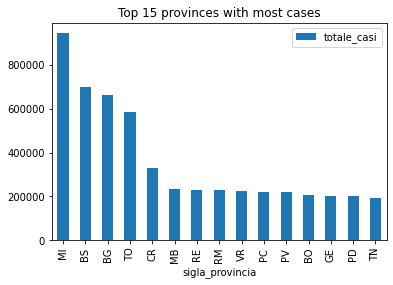

In [4]:
# group by "sigla_provincia" and sum all the values. Then drop 'lat' and 'long' columns and show 
# the top 15 provinces with the highest value on 'totale_casi'
dati.groupby(['sigla_provincia']).sum().drop(columns=['lat', 'long']).nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 15 provinces with most cases") # I don't know why this 'plt.title()' is working 
#but the others right below don't

In [5]:
# Get the provinces name (Sigle)
provinces = dati.sigla_provincia.unique()
# Create a DataFrame with total cases per month for each province
cases_per_month = {}

for province in provinces: 
    province_info = dati.loc[province]
    # The 'groupby(province_info.data.str[:7]' is used to group the rows according to the month
    # The [:7] is used to slice the first t letters of the 'data' column
    # 2020-05-15T17:00:00 ---> 2020-05
    # And finally sum the 'totale_casi' values grouped by month for each province
    cases_per_month[province] = pd.Series(province_info.groupby(province_info.data.str[:7])['totale_casi'].sum())

# Create the DataFrame using the Series defined in the for loop
cpm = pd.DataFrame(cases_per_month)
cpm.index.name = "" # Works fine even without this line, but there was an empty line that was bothering me
cpm = cpm.T # For a better view
cpm

,2020-02,2020-03,2020-04,2020-05
,198,39032,86204,60379
AG,0,878,3697,2615
AL,0,14258,74646,70245
AN,0,12655,47962,34855
AO,0,6155,28725,21967
...,...,...,...,...
VE,63,14442,58689,48967
VI,9,12855,63618,52510
VR,0,20883,108498,93385
VT,0,1697,9546,7749


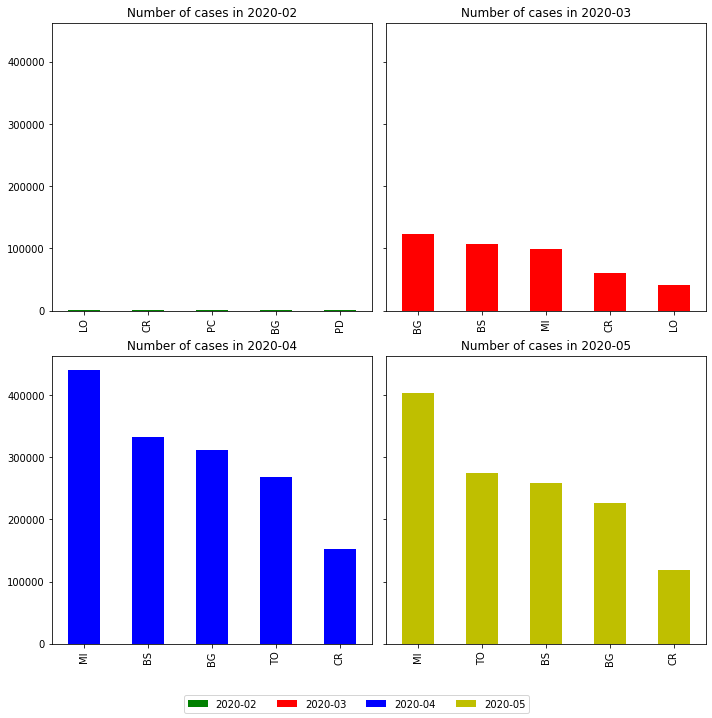

In [6]:
grid_size = (2,2) # For the 4 month considered
colors = ['g', 'r', 'b', 'y']
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharey=True, figsize=(10,10))
cities_with_worst_cases = [] # Store the name of the cities with the worst cases

month = 0
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        # Cities twith the worst cases in the current month
        worst_cases = cpm.nlargest(5, cpm.columns[month])[cpm.columns[month]]
        worst_cases.plot(ax=axes[i,j], kind='bar', legend=False, color=colors[month])
        axes[i, j].set_title('Number of cases in '+cpm.columns[month]) # Doesn't work
        cities_with_worst_cases.append(worst_cases)
        month += 1
        
fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=cpm.columns, loc="lower center", ncol=4)

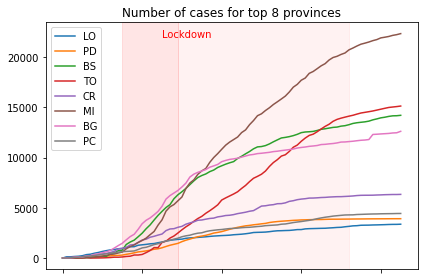

In [127]:
# Create a set of the cities with the worst case 
interested_city = list(set([item for sublist in [list(city.index) for city in cities_with_worst_cases] for item in sublist]))


# Collect information about these cities day by day
for i in range(len(interested_city)):
    dati.loc[interested_city[i]]['totale_casi'].plot(
        kind='line', 
        label=interested_city[i], 
        title="Number of cases for top 8 provinces").set_xticklabels([])
    #plt.plot(list(range(len(case_per_day))), case_per_day, label=interested_city[i], title="wooo")
    

plt.text(25, 22000, "Lockdown", color="r")
plt.axvspan(15, 29, color='red', alpha=0.1)
plt.axvspan(29, 72, color='red', alpha=0.05)
plt.tight_layout()
plt.legend()


In [9]:
data = []
for region in covid19_regions_data:
    region_denomination = region['denominazione_regione']
    region_date = region['data']
    data.append([region_denomination, region_date, region.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
region_info = []
for region in data:
    index.append([region[0], region[1]]) # (Name, date)
    region_info.append(region[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
regions_data_frame = pd.DataFrame(region_info, index=index, columns=covid19_regions_data[0].keys()).fillna(0)
regions_data_frame = regions_data_frame.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'note_it', 'note_en', 'lat', 'long'])
regions_data_frame

ricoverati_con_sintomi  terapia_intensiva  \
Abruzzo 2020-02-24T18:00:00                       0                  0   
        2020-02-25T18:00:00                       0                  0   
        2020-02-26T18:00:00                       0                  0   
        2020-02-27T18:00:00                       1                  0   
        2020-02-28T18:00:00                       1                  0   
...                                             ...                ...   
Veneto  2020-05-15T17:00:00                     311                 24   
        2020-05-16T17:00:00                     290                 20   
        2020-05-17T17:00:00                     273                 22   
        2020-05-18T17:00:00                     263                 22   
        2020-05-19T17:00:00                     259                 18   

                             totale_ospedalizzati  isolamento_domiciliare  \
Abruzzo 2020-02-24T18:00:00                     0                       0   
        2020-02-25T18:00:00                     0                       0   
        2020-02-26T18:00:00                     0                       0   
        2020-02-27T18:00:00                     1                       0   
        2020-02-28T18:00:00                     1                       0   
...                                           ...                     ...   
Veneto  2020-05-15T17:00:00                   335                    4104   
        2020-05-16T17:00:00                   310                    3852   
        2020-05-17T17:00:00                   295                    3746   
        2020-05-18T17:00:00                   285                    3719   
        2020-05-19T17:00:00                   277                    3477   

                             totale_positivi  variazione_totale_positivi  \
Abruzzo 2020-02-24T18:00:00                0                           0   
        2020-02-25T18:00:00                0                           0   
        2020-02-26T18:00:00                0                           0   
        2020-02-27T18:00:00                1                           1   
        2020-02-28T18:00:00                1                           0   
...                                      ...                         ...   
Veneto  2020-05-15T17:00:00             4439                        -279   
        2020-05-16T17:00:00             4162                        -277   
        2020-05-17T17:00:00             4041                        -121   
        2020-05-18T17:00:00             4004                         -37   
        2020-05-19T17:00:00             3754                        -250   

                             nuovi_positivi  dimessi_guariti  deceduti  \
Abruzzo 2020-02-24T18:00:00               0                0         0   
        2020-02-25T18:00:00               0                0         0   
        2020-02-26T18:00:00               0                0         0   
        2020-02-27T18:00:00               1                0         0   
        2020-02-28T18:00:00               0                0         0   
...                                     ...              ...       ...   
Veneto  2020-05-15T17:00:00              44            12688      1762   
        2020-05-16T17:00:00              39            12983      1783   
        2020-05-17T17:00:00              13            13106      1794   
        2020-05-18T17:00:00               9            13143      1803   
        2020-05-19T17:00:00              47            13423      1820   

                             totale_casi  tamponi  casi_testati  
Abruzzo 2020-02-24T18:00:00            0        5           0.0  
        2020-02-25T18:00:00            0        5           0.0  
        2020-02-26T18:00:00            0       13           0.0  
        2020-02-27T18:00:00            1       33           0.0  
        2020-02-28T18:00:00            1       33           0.0  
...              

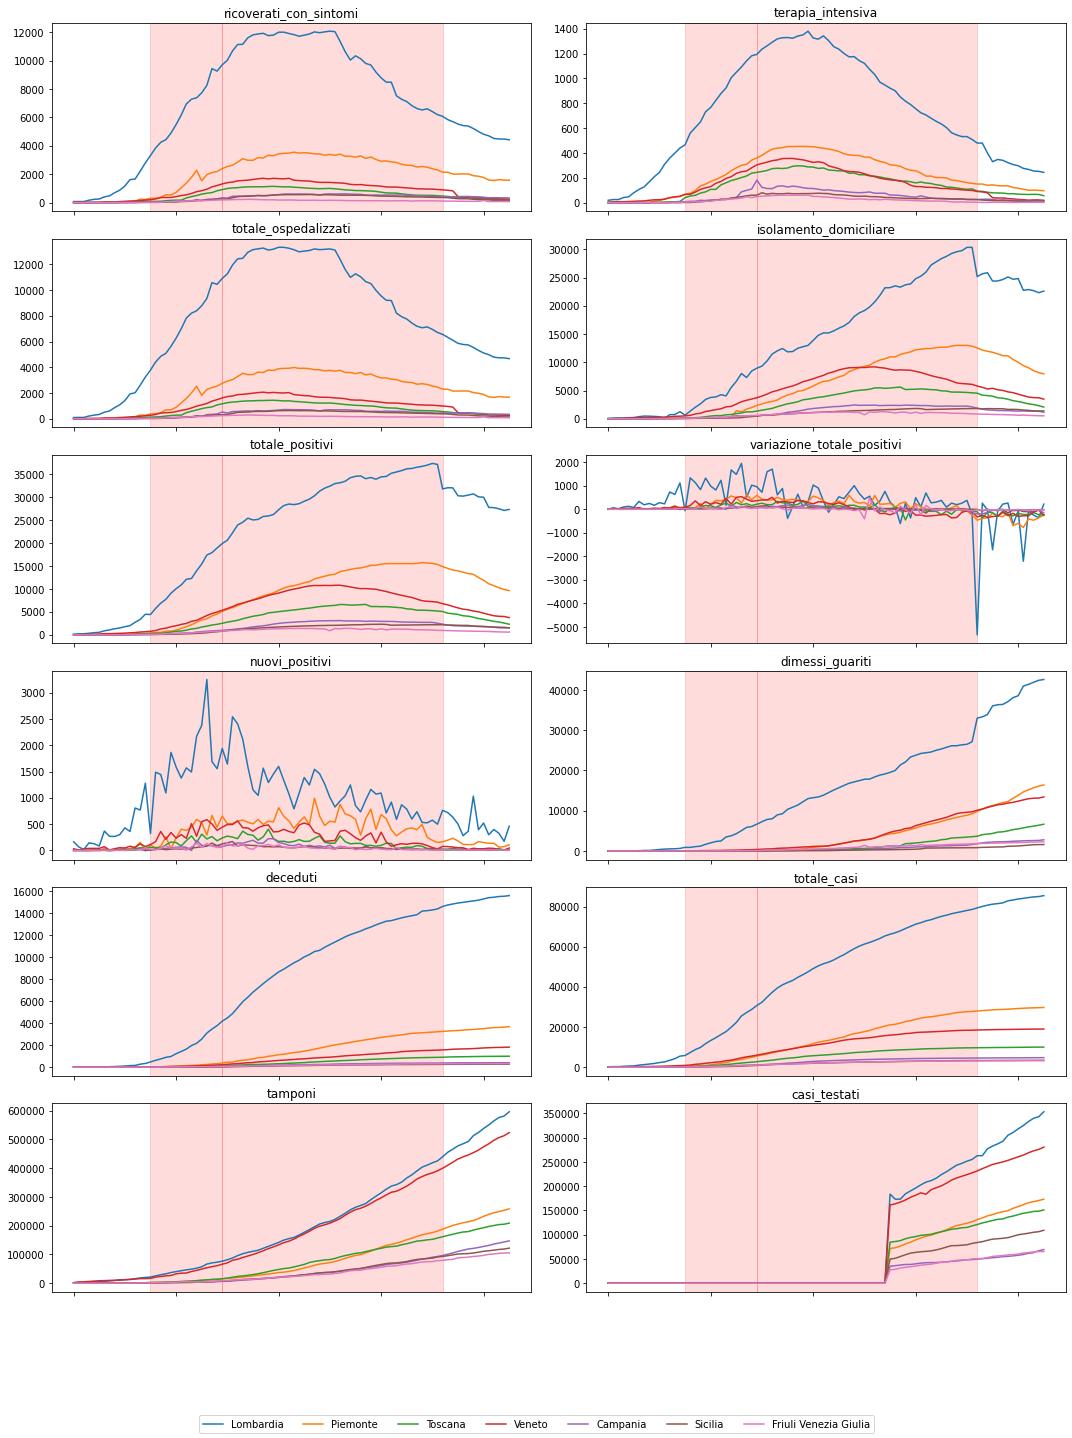

In [128]:
regions_considered = ['Lombardia', 'Piemonte', 'Toscana', 'Veneto', 'Campania', 'Sicilia', 'Friuli Venezia Giulia']
grid_size = (6, 2) # (#regions x #columns's info)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharex=True, figsize=(15,20))

i = 0
r, c = (0,0)
for column_info in regions_data_frame.columns:
    for region in regions_considered:
        regions_data_frame.loc[region][column_info].plot(ax=axes[r,c], kind='line', title=column_info)
        axes[r,c].axvspan(29, 72, color='red', alpha=0.02)
        axes[r,c].axvspan(15, 29, color='red', alpha=0.02)
        axes[r,c].set_xticklabels([])
    
    c = (c+1)%grid_size[1]
    if c == 0:
        r+=1
#a.plot(kind='line', legend=True)
#plt.ylabel("intensive care")
#ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=regions_considered, loc="lower center", ncol=len(regions_considered))